In [17]:
import sys
sys.path.append('../src')

import typing as tp
from pathlib import PosixPath

import cv2
import matplotlib.pyplot as plt
import numpy as np

from data.convolution import convolve
from deconv.classic.wiener import wiener_gray
from imutils import imshow, imsshow, load_npy, rgb2gray

In [2]:
def imread_srgb8bit(img_path: tp.Union[str, PosixPath]) -> np.array:
    """Read image in sRGB (output.dtype = np.uint8)"""
    img_path = str(img_path) if not isinstance(img_path, str) else img_path
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
def imread_float(img_path: tp.Union[str, PosixPath]) -> np.array:
    image = imread_srgb8bit(img_path)
    return (image / 255).astype(np.float32)

In [6]:
image_srgb8 = imread_srgb8bit('../datasets/gt/BSDS300/2092.jpg')
image_srgb8.dtype

dtype('uint8')

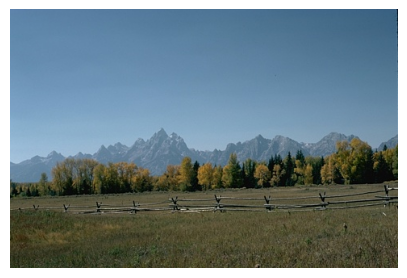

In [7]:
imshow(image_srgb8, (5, 5))

In [8]:
# def srgb2float(image: np.array) -> np.array:
#     assert image.dtype == np.uint8
#     return image / 255.

In [19]:
def float2srgb8(image: np.array) -> np.array:
    assert image.dtype in [np.float32, np.float64]
    return (image * 255).astype(np.uint8)

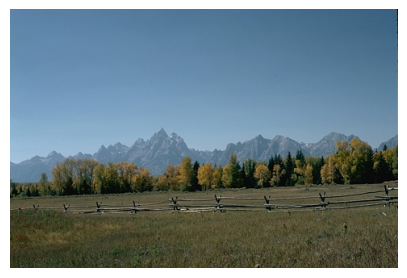

In [12]:
image_float = srgb2float(image_srgb8)

imshow(image_float, (5, 5))

In [10]:
def srgb2linrgb16(image_srgb: np.array) -> np.array:
    """Convert 8-bit sRGB to 16-bit linRGB"""
    
    if image_srgb.dtype == np.uint8:
        image_srgb = image_srgb / 255
        
    mask = image_srgb <= 0.04045

    image_srgb[mask] = image_srgb[mask] / 12.92
    image_srgb[np.invert(mask)] = np.power((image_srgb[np.invert(mask)] + 0.055) / 1.055, 2.4)
    return (image_srgb * 65535).astype(np.uint16)

In [9]:
def float2srgb8(image: np.array) -> np.array:
    assert image.dtype in [np.float32, np.float64]
    return (image * 255).astype(np.uint8)

# Pipeline

In [29]:
kernel = load_npy('../datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy', key='psf')
image = imread_float('../datasets/gt/BSDS300/2092.jpg')

# works in float
image = rgb2gray(image)
blurred_float = convolve(image, kernel)
restored_float = wiener_gray(blurred_float, kernel, clip=True, balance=0)

# works in sRGB 8-bit 
image_srgb8 = float2srgb8(image)
blurred_srgb8 = float2srgb8(blurred_float)
restored_srgb8 = wiener_gray(blurred_srgb8 / 255, kernel, clip=True, balance=1e-3)

# works in linRGB 16-bit
image_linrgb16 = srgb2linrgb16(image)
blurred_linrgb16 = srgb2linrgb16(blurred_srgb8)
restored_linrgb16  = wiener_gray(blurred_linrgb16 / 65535, kernel, clip=True, balance=1e-3)


NameError: name 'imread_float' is not defined

<Figure size 640x480 with 0 Axes>

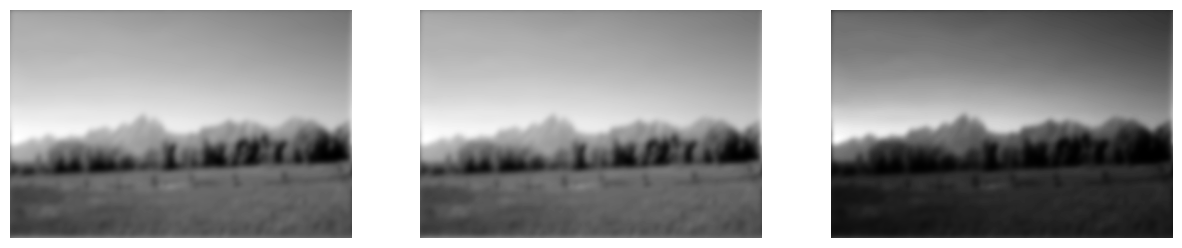

In [44]:
plt.gray()
imsshow([blurred_float, blurred_srgb8 / 255, blurred_linrgb16 / 65535], (15, 8))

<Figure size 640x480 with 0 Axes>

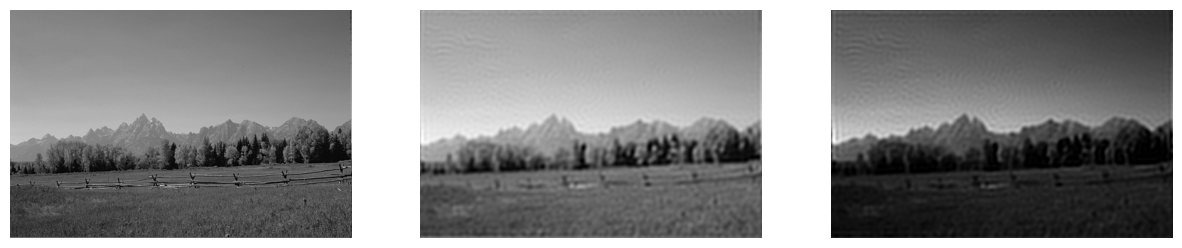

In [45]:
plt.gray()
imsshow([restored_float, restored_srgb8 * 255, restored_linrgb16], (15, 8))

### PNG & JPG

In [1]:
import sys
sys.path.append('../src')

import typing as tp
from pathlib import PosixPath

import cv2
import matplotlib.pyplot as plt
import numpy as np

from data.convolution import convolve
from data.convertation import float2srgb8, srgb2linrgb16
from deconv.classic.wiener.wiener import wiener_gray
from imutils import imshow, imsshow, load_npy, rgb2gray, make_noised

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def imread(img_path: str) -> np.array:
    img_path = str(img_path) if not isinstance(img_path, str) else img_path
    return plt.imread(img_path)

image_path_png = '../datasets/gt/Sun-gray/im_1.png'
im_png = plt.imread(image_path_png)
print(im_png.dtype)               # float32

image_path_jpg = '../datasets/gt/BSDS300/2092.jpg'
im_jpg = plt.imread(image_path_jpg)
print(im_jpg.dtype) 

float32
uint8


In [3]:
kernel = load_npy('../datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy', key='psf')

#### png

In [5]:
image = im_png

# works in float
blurred_float = convolve(image, kernel)
restored_float = wiener_gray(blurred_float, kernel, clip=True, balance=0)

In [6]:
blurred_float.dtype

dtype('float32')

<Figure size 640x480 with 0 Axes>

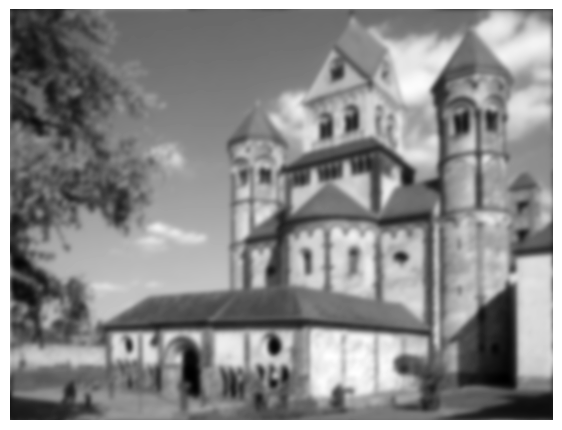

In [7]:
plt.gray()
imshow(blurred_float, (7,  7))

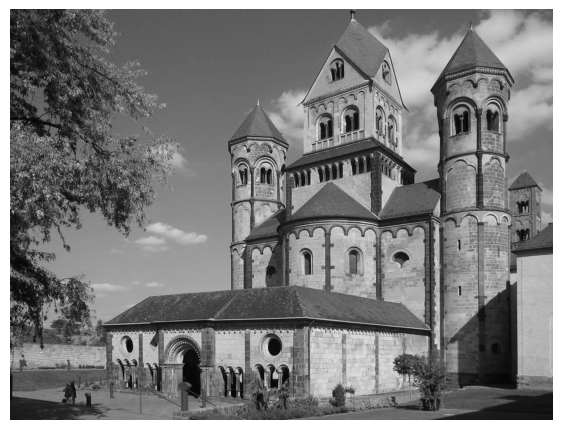

In [8]:
imshow(restored_float, (7,  7))

In [9]:
# works in sRGB 8 bit

blurred_srgb = float2srgb8(blurred_float)
restored_srgb = wiener_gray(blurred_srgb / 255, kernel, clip=True, balance=1e-3)

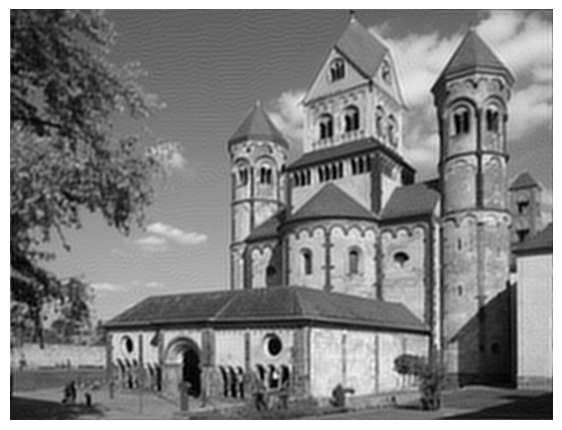

In [10]:
imshow(restored_srgb, (7,  7))

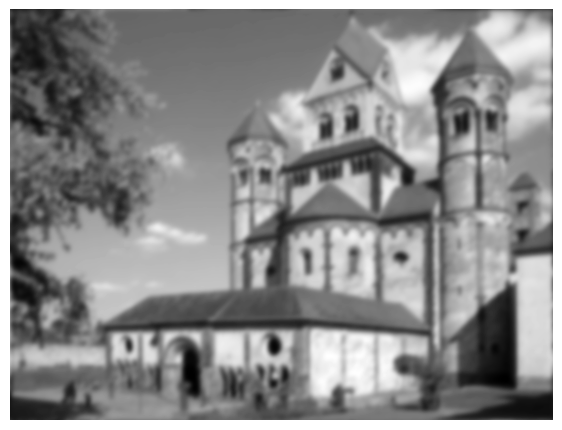

In [17]:
imshow(blurred_srgb, (7,  7))

In [12]:
# works in linear RGB

blurred_linrgb = srgb2linrgb16(blurred_srgb)
restored_linrgbb = wiener_gray(blurred_linrgb / 65535, kernel, clip=True, balance=1e-2)

In [14]:
restored_linrgbb

array([[0.02240587, 0.01705725, 0.01245221, ..., 0.03221362, 0.0308449 ,
        0.02735961],
       [0.03482531, 0.02513356, 0.01717416, ..., 0.05935682, 0.05330859,
        0.0447394 ],
       [0.04988232, 0.03567816, 0.02434088, ..., 0.09089087, 0.07940041,
        0.06514711],
       ...,
       [0.00994342, 0.01167742, 0.01272236, ..., 0.00020975, 0.00405016,
        0.00738452],
       [0.0101156 , 0.01071498, 0.01083311, ..., 0.00237574, 0.00601918,
        0.00862502],
       [0.01404118, 0.01225307, 0.01045593, ..., 0.01276997, 0.01471909,
        0.01506575]])

<Figure size 640x480 with 0 Axes>

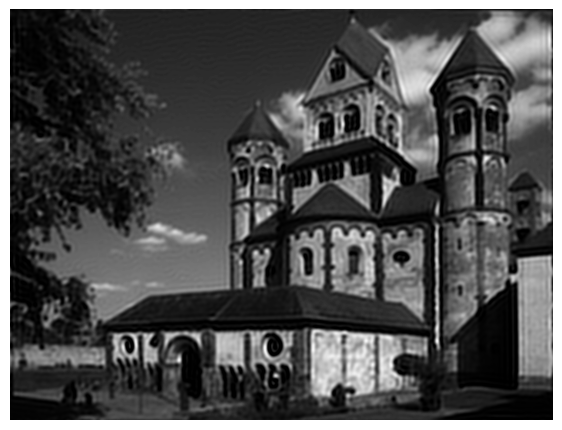

In [13]:
plt.gray()
imshow(restored_linrgbb, (7,  7))

### jpg

In [4]:
image = im_jpg
if image.ndim == 3:
    image = rgb2gray(image)
    image = float2srgb8(image)
blurred = convolve(image, kernel).astype(np.uint8)
noised_blurred = make_noised(blurred, 0, 0.01).astype(np.uint8)

In [6]:
blurred.dtype

dtype('uint8')

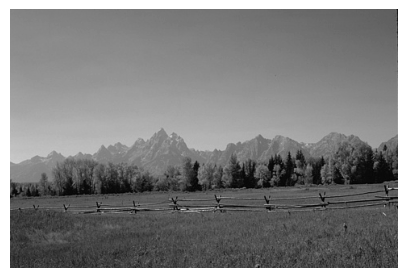

In [8]:
imshow(image, (5, 5))

<Figure size 640x480 with 0 Axes>

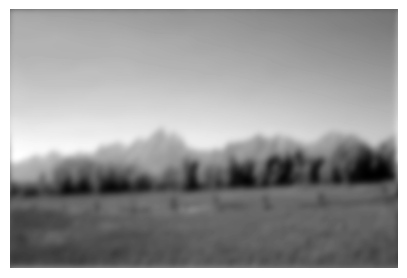

In [7]:
plt.gray()
imshow(blurred, (5, 5))

In [13]:
image.dtype

dtype('uint8')

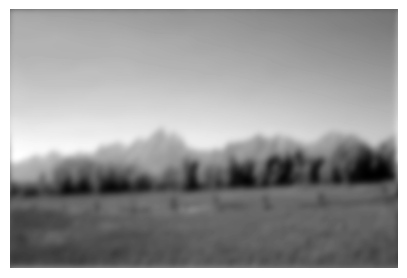

In [24]:
imshow(blurred, (5, 6))

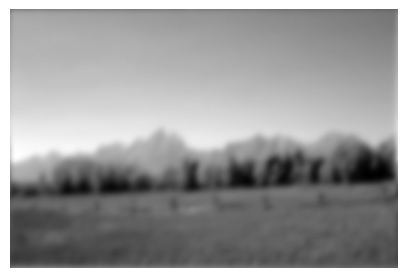

In [28]:
imshow(noised_blurred, (5, 6))

In [21]:
import numpy as np
from PIL import Image

im = Image.open('../datasets/gt/Sun-gray/im_1.png')
# im.load()

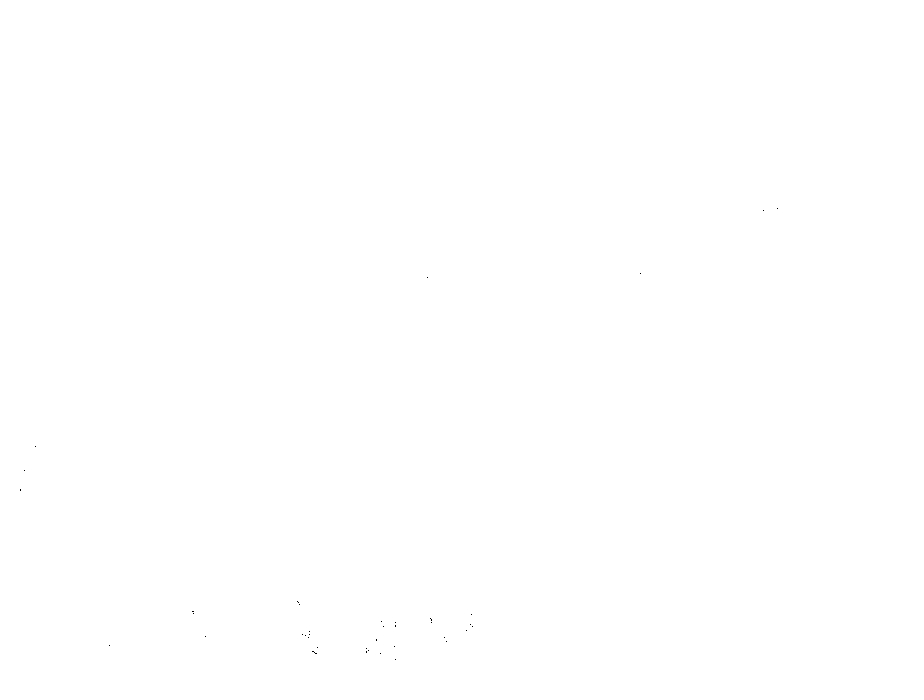

In [24]:
im.point(lambda i: i * (1 * 255)).convert("RGB")

In [22]:
# np.asarray(im)

array([[64, 48, 16, ..., 86, 88, 89],
       [89, 81, 38, ..., 86, 88, 90],
       [58, 69, 66, ..., 88, 89, 91],
       ...,
       [29, 27, 25, ..., 20, 20, 20],
       [26, 23, 22, ..., 20, 20, 20],
       [25, 24, 22, ..., 21, 21, 21]], dtype=uint8)